# Building the application code

Here we now want to combine the code we gathered so far (nucleus detection, subimaging, generated model) to generate a pipeline that is the basis for the final web application that we will generate with streamlit.

# How to build up the final application

Here are some thoughts on how we want to structure the app in the end. This is the basis for the structure of the code below

1. We need to be able to upload an image. It needs to be a merged image. The user needs to input the image path
2. Isolate the DAPI channel of the image and save it.
3. Get input of the user for the nucleus detection. Inputs to detect the correct shapes: 
    - Kernelsize to fill wholes in the objects (default is 5, which makes a 5x5 kernel, it should be smaller, if objects need to be better separated, but it is too small, segmented nuclei will be detected worse)
    - diversion from an aspection ratio of 1 (range: 0-1, default is 0.4, an aspect ratio of 1 is for perfect round shapes, it is a ratio of width and height, the number given here will be subtracted from 1, thus the closer to one the input, the less the restriction)
    - diversion from a circularity of 1 (range: 0-1, default is 0.7, a circularity of 1 is for perfect round shapes, the number given here will be subtracted from 1, thus the closer to one the input, the less the restriction)
    - max and min shape size (default min at 300 and max at 10000, which is hardly any restriction)
    - checkbox, if the user wants to have all the intermediate images (nucleus detection and subimages)
4. Give out nucleus detection images to the user. The user can confirm them (continue with the program) or deny them to change the settings further
5. Use the coordinates from the nucleus detection to generate the subimages from the merged image
6. Run preprocessing with the subimages: grey scale conversion, standardisation, PCA, then run the logistic regression
7. Output: intermediate images, if ticked earlier. Otherwise give a spreadsheet with the image name (mother image name and subimage number), the predicted category, the probabilites for each category and the total counts of both categories for the mother image

In [1]:
# import the needed packages
import cv2
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# user input for the nucleus detection

image_path = '../data/untouched_images/pma'

subimages_output_folder = "../data/subimages"

# size of the kernel that is used to close holes in objects (if smaller the objects are more separated). inputing 5 will generate a 5x5 kernel
kernelsize = 5

# aspect ratio treshold, how much is the shape allowed from the ratio of 1, which would indicate that hight and width are identical (0.4 was good)
aspect = 1

# circularity treshold, it is 1 for a perfect circle. How much is the object allowed to diverge from that? (0.7 was good)
circ = 1

# decide for min and max area of the detected object
min_size = 300
max_size = 10000

# if this boolean is set to True, you will follow the nuclei detection for each image one by one and have to push any button to continue
follow_nuclei_detection = False

In contrast to the original nucleus detection code, we want for the final application that user only gives the multi-channel image as input. Thus, we first need code to extract the blue channel.

In [3]:
# Function to load a TIFF image, split into channels, and save the blue channel and the whole image

def process_image(image_path):
    ''' 
    Function loads a three-channel image and splits off the blue channel.
    image_path: give the path to the image
    returns the multi-channel image and the nucleus channel
    '''
    image = Image.open(image_path)
    image_array = np.array(image)
    print(image_array.shape)
    # Ensure the image has three channels (RGB)
    if len(image_array.shape) != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image must be an RGB image.")
    # Extract the blue channel (DAPI channel). If the nucleus channel is in a different position of the image (e.g. in the green channel instead of the blue one), here is the position where to change
    # the channel that is used for nucleus detection. Just change the 2 below for a 1 or 0 depending on where the channel is positioned
    dapi_channel = image_array[:, :, 2]
    # image_array is the full multi-channel image, dapi_channel is the nucleus channel
    return image_array, dapi_channel


In [4]:
# Function to detect the nuclei
def detect_objects2(image_array, output_dir, image_name, kernelsize, aspect, circ, min_size, max_size, follow_nuclei_detection=False):
    '''
    Function detects nucleus center coordinates.
    image_array: give the blue-channel arrays extracted with the process_image function
    output_dir: give the path where the nucleus detected images are supposed to be saved
    additional input is the user input for defining the shape of the objects to be detected
    returns a list with the nucleus center coordinates
    '''
    if len(image_array.shape) != 2:
        raise ValueError("Expected grayscale image")
    blurred = cv2.GaussianBlur(image_array, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    kernel = np.ones((kernelsize, kernelsize), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    dilated = cv2.dilate(closing, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_image = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)
    coordinates = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            if 1 - aspect <= aspect_ratio <= 1 + aspect and circularity > 1 - circ and min_size <= area <= max_size:
                coordinates.append((cX, cY))
                cv2.circle(color_image, (cX, cY), 5, (0, 0, 255), -1)
    output_image_path = os.path.join(output_dir, f"{image_name}_detected_centers.png")
    cv2.imwrite(output_image_path, color_image)
    if follow_nuclei_detection:
        cv2.imshow("Detected Centers", color_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return coordinates

In [5]:
# now we use these coordinates to do the subimaging on the merge-channel images

# Function to extract sub-images around detected nuclei
def extract_sub_images(image_array, coordinates, output_dir, image_name):
    ''' 
    Function extracts the subimages around the coordinates given.
    image_array: give the multi-channel image array obtained from the process_image function
    coordinates: list of nucleus center coordinates (from detect_objects2 function)
    output_dir: give path for output of the subimages
    image_name: name of the original image
    returns a list of the subimages
    '''
    if image_array is None:
        raise ValueError("Image array is None")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    sub_images = []
    for i, (cX, cY) in enumerate(coordinates):
        startX = max(cX - 30, 0)
        startY = max(cY - 30, 0)
        endX = min(cX + 30, image_array.shape[1])
        endY = min(cY + 30, image_array.shape[0])
        sub_image = image_array[startY:endY, startX:endX]
        sub_images.append(sub_image)
        sub_image_path = os.path.join(output_dir, f"{image_name}_sub_image_{i}.png")
        cv2.imwrite(sub_image_path, cv2.cvtColor(sub_image, cv2.COLOR_RGB2BGR))
    return sub_images

In [6]:
# Main function to process images
def main(image_path, subimages_output_folder, kernelsize, aspect, circ, min_size, max_size):
    ''' 
    Funtion that puts together all the functions defined above to extract the subimages.
    image_path: path to the multi-channel images
    subimages_output_folder: base folder for the image output
    give all the user input for the object detection
    returns the list of subimage_lists, the timestamp of image generation and a list with the image names
    '''
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    output_folder = os.path.join(subimages_output_folder, f"output_{timestamp}")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    nuclei_detection_output_dir = os.path.join(output_folder, "nucleus_detection")
    if not os.path.exists(nuclei_detection_output_dir):
        os.makedirs(nuclei_detection_output_dir)
    image_files = [f for f in os.listdir(image_path) if f.endswith('.tif') or f.endswith('.tiff')]
    subimages = []
    for image_file in image_files:
        image_path2 = os.path.join(image_path, image_file)
        whole_image, dapi_channel = process_image(image_path2)
        if len(dapi_channel.shape) == 3:
            dapi_channel = cv2.cvtColor(dapi_channel, cv2.COLOR_BGR2GRAY)
        print(f"Processed image: {image_file}")
        print("Whole image shape:", whole_image.shape)
        print("DAPI channel shape:", dapi_channel.shape)
        coordinates = detect_objects2(dapi_channel, nuclei_detection_output_dir, os.path.splitext(image_file)[0], kernelsize, aspect, circ, min_size, max_size)
        sub_image_output_dir = os.path.join(output_folder, 'subimages')
        if not os.path.exists(sub_image_output_dir):
            os.makedirs(sub_image_output_dir)
        subimage = extract_sub_images(whole_image, coordinates, sub_image_output_dir, os.path.splitext(image_file)[0])
        subimages.append(subimage)
    return subimages, timestamp, image_files

In [7]:
# running the nucleus detection and the subimages. Output: a list with all the subimages. It should be a list with lists of the subimages
subimages, timestamp, image_files = main(image_path, subimages_output_folder, kernelsize, aspect, circ, min_size, max_size)

(1024, 1024, 3)
Processed image: PMA_1.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)
(1024, 1024, 3)
Processed image: PMA_2.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)
(1024, 1024, 3)
Processed image: PMA_3.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)


In [8]:
# Function to display the first three subimages of each image in subimages
def display_first_three_subimages(subimages):
    for i, image_list in enumerate(subimages):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'First 3 Subimages for Image {i+1}', fontsize=16)
        for j in range(3):
            if j < len(image_list):
                sub_image = image_list[j]
                axes[j].imshow(sub_image)
                axes[j].axis('off')
                axes[j].set_title(f'Subimage {j+1}')
            else:
                axes[j].axis('off')
        plt.show()

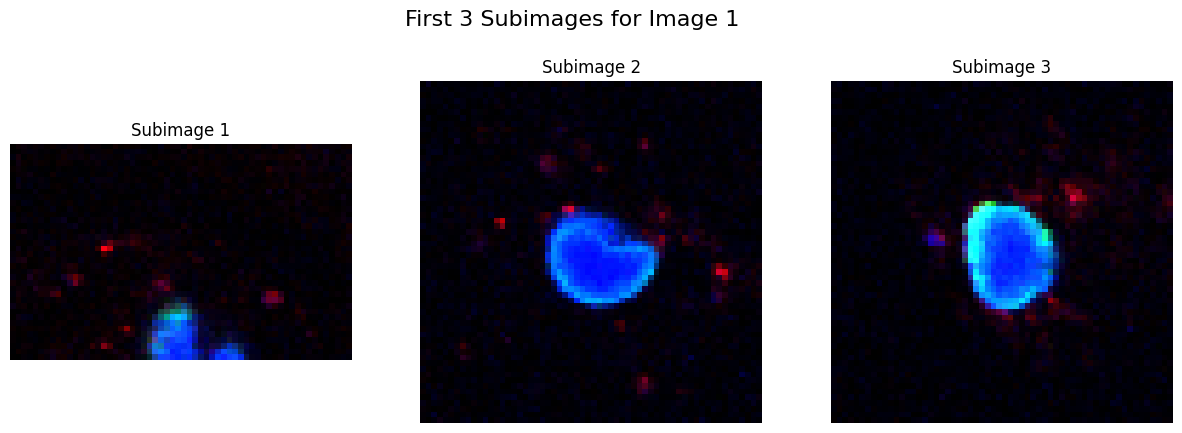

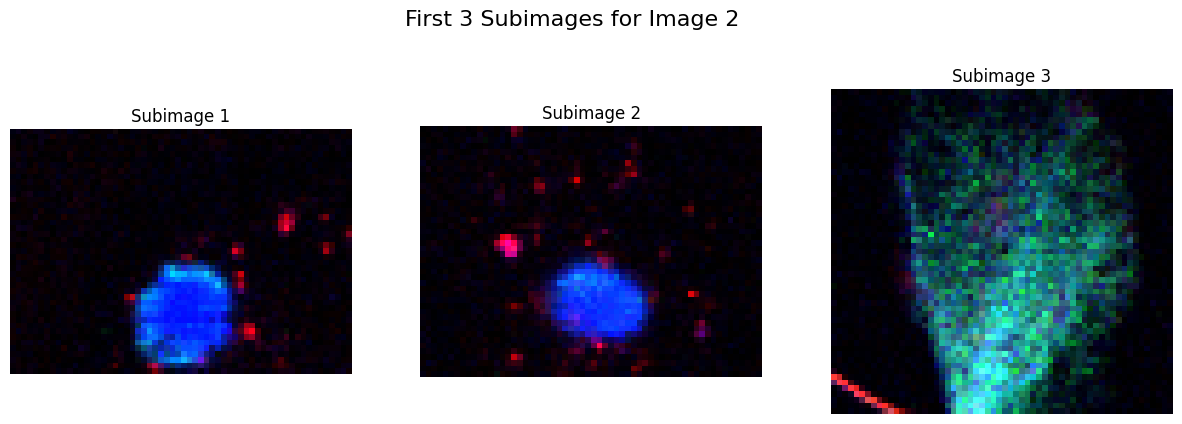

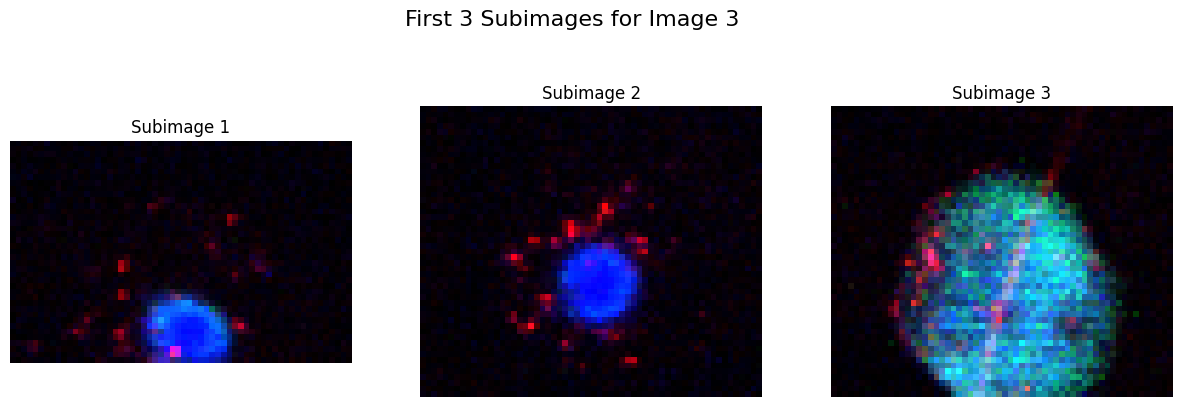

In [9]:
display_first_three_subimages(subimages)

## Predictions

Now the pipeline for the subimage generation is set up. These subimages are now used for prediction with the models generated elsewhere and saved as pkl-file.

In [11]:
# Load the trained logistic regression model, StandardScaler, and PCA
MODEL_SAVE_PATH = '../models/logistic_regression_model_DOP_v2.pkl'
SCALER_SAVE_PATH = '../models/scaler_v2.pkl'
PCA_SAVE_PATH = '../models/pca_v2.pkl'

model = joblib.load(MODEL_SAVE_PATH)
scaler = joblib.load(SCALER_SAVE_PATH)
pca = joblib.load(PCA_SAVE_PATH)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def predict_image(image_path, model, scaler, pca, img_size=IMG_SIZE):
    ''' 
    Function loads the generated subimages and preprocesses them like the images were preprocessed before modelling
    image_path: give the path to the subimages
    model: trained model that was loaded before
    scaler: used scaler that was loaded before
    pca: used pca that was loaded before
    returns the predicted class (argmax) and the prediction probabilities
    '''
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image

    # Apply StandardScaler and PCA
    img_array_scaled = scaler.transform(img_array)
    img_array_pca = pca.transform(img_array_scaled)

    # Make a prediction
    prediction_prob = model.predict_proba(img_array_pca)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    return predicted_class, prediction_prob

def predict_and_save_results(subimages_folder, model, scaler, pca, output_csv_path):
    ''' 
    Function iterates through the subimages using the predict_image function.
    subimages_folder: path to the subimages
    model: trained model that was loaded before
    scaler: used scaler that was loaded before
    pca: used pca that was loaded before
    output_csv_path: give the path where the csv files are supposed to be saved
    returns a dataframe with the original name of the image, the subimage number, the predicted category and the prediction probabilities
    '''
    results = []

    for root, dirs, files in os.walk(subimages_folder):
        for file in files:
            if file.endswith('.png'):
                print(file)
                image_path = os.path.join(root, file)
                predicted_class, prediction_prob = predict_image(image_path, model, scaler, pca)

                # Extract original image name and subimage number from file path
                original_image_name = os.path.basename(file)
                index = original_image_name.find('_sub_image')
                original_image_name = original_image_name[:index]
                subimage_number = file.split('_')[-1].split('.')[0]

                # Append result to the list
                results.append({
                    'Original Image': original_image_name,
                    'Subimage Number': subimage_number,
                    'Predicted Category': predicted_class,
                    'Probabilities': prediction_prob.tolist()  # Convert array to list for CSV
                })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

    return results_df

# Predict and save results for all subimages
subimages_folder = os.path.join(subimages_output_folder, f"output_{timestamp}", 'subimages')  # Adjust the path to your subimages folder
output_csv_path = f'results/{timestamp}_predictions_subimages.csv'
results_df = predict_and_save_results(subimages_folder, model, scaler, pca, output_csv_path)


PMA_1_sub_image_67.png
PMA_1_sub_image_73.png
PMA_2_sub_image_3.png
PMA_2_sub_image_86.png
PMA_3_sub_image_27.png
PMA_3_sub_image_33.png
PMA_2_sub_image_79.png
PMA_2_sub_image_45.png
PMA_2_sub_image_51.png
PMA_2_sub_image_50.png
PMA_2_sub_image_44.png
PMA_2_sub_image_78.png
PMA_3_sub_image_32.png
PMA_2_sub_image_87.png
PMA_3_sub_image_26.png
PMA_2_sub_image_2.png
PMA_1_sub_image_72.png
PMA_1_sub_image_66.png
PMA_1_sub_image_58.png
PMA_1_sub_image_70.png
PMA_1_sub_image_64.png
PMA_2_sub_image_0.png
PMA_3_sub_image_18.png
PMA_3_sub_image_30.png
PMA_3_sub_image_24.png
PMA_2_sub_image_85.png
PMA_2_sub_image_52.png
PMA_2_sub_image_46.png
PMA_2_sub_image_47.png
PMA_2_sub_image_53.png
PMA_3_sub_image_25.png
PMA_2_sub_image_84.png
PMA_3_sub_image_31.png
PMA_3_sub_image_19.png
PMA_2_sub_image_1.png
PMA_1_sub_image_65.png
PMA_1_sub_image_71.png
PMA_1_sub_image_59.png
PMA_1_sub_image_75.png
PMA_1_sub_image_61.png
PMA_1_sub_image_49.png
PMA_2_sub_image_5.png
PMA_3_sub_image_35.png
PMA_2_sub_image_

Now, the main part is done. We have predictions for each and every subimage in a csv file/dataframe. Now I wand to make sense out of them. Below, I will generate a pipeline to get an automated quantification.

In [12]:
results_df

,Original Image,Subimage Number,Predicted Category,Probabilities
0,PMA_1,67,0,"[[0.9726907458270851, 0.027309254172914847]]"
1,PMA_1,73,1,"[[0.04924419630511345, 0.9507558036948865]]"
2,PMA_2,3,1,"[[0.343401265542816, 0.656598734457184]]"
3,PMA_2,86,1,"[[0.49231249517220455, 0.5076875048277955]]"
4,PMA_3,27,0,"[[0.9959777896650749, 0.004022210334925081]]"
...,...,...,...,...
249,PMA_2,60,0,"[[0.9768037979885719, 0.02319620201142811]]"
250,PMA_3,16,0,"[[0.9994770060753215, 0.0005229939246784959]]"
251,PMA_1,81,0,"[[0.9409970986144748, 0.05900290138552518]]"
252,PMA_1,56,0,"[[0.9793188453242828, 0.020681154675717153]]"


In [13]:
# I want to sort the dataframe in a way that we get the counts for NET positive/negative cells for each original image
image_summary = results_df[['Original Image', 'Predicted Category', 'Subimage Number']].groupby(['Original Image','Predicted Category']).count().reset_index()

In [14]:
# I used entries in Subimage Number for counting the events. This reflects the counted images in each condition
image_summary.rename(columns={'Subimage Number': 'Cell Count'}, inplace=True)

In [15]:
# replace the 0 and 1 with the real category names
image_summary['Predicted Category'] = image_summary['Predicted Category'].replace({0: 'NET negative', 1: 'NET positive'})

In [16]:
image_summary

,Original Image,Predicted Category,Cell Count
0,PMA_1,NET negative,61
1,PMA_1,NET positive,26
2,PMA_2,NET negative,66
3,PMA_2,NET positive,23
4,PMA_3,NET negative,49
5,PMA_3,NET positive,29


In [18]:
# calculate the NET positive ratio, which is what our stakeholders use as a main read-out for their experiments. It is the amount of NET positive cells / all cells in percent.

percents = []
iteration_stop = image_summary.shape[0] - 1

for i, h in image_summary.iterrows():
    # the for loop has to stop before the last row and only take into account every second row
    if i < iteration_stop and i % 2 == 0:
        ratio = image_summary['Cell Count'][i+1] / (image_summary['Cell Count'][i] + image_summary['Cell Count'][i+1]) * 100
        percents.append(ratio)
        percents.append(ratio)

In [19]:
# add the NET positive ration to the data frame
image_summary['NET Positive Ratio'] = percents

In [20]:
image_summary

,Original Image,Predicted Category,Cell Count,NET Positive Ratio
0,PMA_1,NET negative,61,29.885057
1,PMA_1,NET positive,26,29.885057
2,PMA_2,NET negative,66,25.842697
3,PMA_2,NET positive,23,25.842697
4,PMA_3,NET negative,49,37.179487
5,PMA_3,NET positive,29,37.179487


In [21]:
output_csv_path2 = f'results/{timestamp}_predictions_whole_image.csv'
# Convert results to DataFrame and save to CSV
image_summary.to_csv(output_csv_path2, index=False)
print(f"Whole image results saved to {output_csv_path2}")

Whole image results saved to results/2024-06-18_11-35_predictions_whole_image.csv


This is already a nice overview table. Now I want to also calculate the mean positive ratio, because probably the user will input a couple of images from the same condition.

In [22]:
image_summary['Original Image']

0    PMA_1
1    PMA_1
2    PMA_2
3    PMA_2
4    PMA_3
5    PMA_3
Name: Original Image, dtype: object

In [23]:
# reduce the data frame to NET positive ratio per original image
df_mean_percent = image_summary[['NET Positive Ratio', 'Original Image']].groupby('Original Image').mean().reset_index()
df_mean_percent

,Original Image,NET Positive Ratio
0,PMA_1,29.885057
1,PMA_2,25.842697
2,PMA_3,37.179487


In [24]:
mean_percent = df_mean_percent['NET Positive Ratio'].mean()
mean_percent

30.96908042665501

In [26]:
# now we make a nice graph with the total cell counts over all images
df_total_sum = image_summary[['Predicted Category', 'Cell Count']].groupby('Predicted Category').sum().reset_index()
df_total_sum

,Predicted Category,Cell Count
0,NET negative,176
1,NET positive,78


Text(0.5, 1.0, 'Total counted cells of all images\nmean NET positive ratio: 30.97')

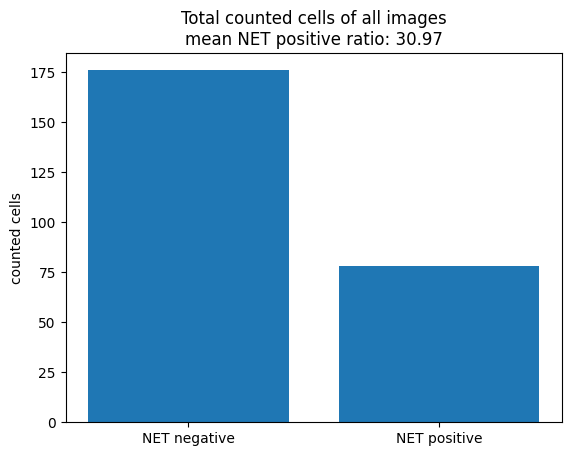

In [28]:
plt.bar(df_total_sum['Predicted Category'], df_total_sum['Cell Count'], width=0.8, align='center', color=None, label=None)
plt.ylabel('counted cells')
plt.title(f'''Total counted cells of all images
mean NET positive ratio: {round(mean_percent,2)}''')

DONE!